# Stock market prediction through numerical and textual analysis

## 1.Importing libraries

In [3]:
#basic libs
import numpy as np
import pandas as pd

#visualization libs
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme="monokai",context="notebook",ticks=True,grid=True)

#warnings
import warnings
warnings.filterwarnings("ignore")

#deep learning libs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Activation

#nlp libs
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.util import *

#preprocessing and metrics
from sklearn import metrics,preprocessing
from sklearn.preprocessing import MinMaxScaler

________________________________________________________________________________________________________________________

## 2.Importing the datasets

In [2]:
#loading the stock prices of apple
df_stock=pd.read_csv("AAPL stock.csv")
#loading the news headlines related to the company
df_news=pd.read_csv("AAPL news.csv")

In [3]:
#displaying the stock prices
df_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-05-22,0.428571,0.430893,0.417857,0.419643,0.360852,412916000
1,2001-05-23,0.424107,0.424107,0.408214,0.414821,0.356706,281041600
2,2001-05-24,0.415893,0.416071,0.403929,0.414286,0.356246,271756800
3,2001-05-25,0.414286,0.415893,0.401786,0.406429,0.349489,158743200
4,2001-05-29,0.398571,0.401786,0.371607,0.383393,0.329681,515989600


In [4]:
#displaying the news headlines
df_news.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [5]:
df_news.tail()

,publish_date,headline_category,headline_text
3424062,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,removed,Govt extends deadline for use of FASTag till F...
3424066,20201231,entertainment.bengali.movies.news,Celebs plan to party safely and responsibly on...


_____________________________________________________________________________________________________

## 3.Feature engineering 

In [6]:
#checking the dimensions of both the datasets
df_stock.shape,df_news.shape

((5032, 7), (3424067, 3))

In [7]:
#checking the columns of the datasets
df_stock.info(),df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5032 entries, 0 to 5031
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5032 non-null   object 
 1   Open       5032 non-null   float64
 2   High       5032 non-null   float64
 3   Low        5032 non-null   float64
 4   Close      5032 non-null   float64
 5   Adj Close  5032 non-null   float64
 6   Volume     5032 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 275.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424067 entries, 0 to 3424066
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 78.4+ MB


(None, None)

### 3.1 stock prices data

In [8]:
# dropping the duplicates
df_stock=df_stock.drop_duplicates()

#converting the date column in type "datetime" column
df_stock["Date"]=pd.to_datetime(df_stock["Date"]).dt.normalize()

#filtering the important columns required
df_stock=df_stock.filter(["Date","Open","High","Low","Close","Volume"])

#setting the "Date" as index
df_stock.set_index("Date",inplace=True)

#Sorting the data based on the index
df_stock=df_stock.sort_index(ascending=True,axis=0)

#viewing the dataset
df_stock

,Open,High,Low,Close,Volume
Date,,,,,
2001-05-22,0.428571,0.430893,0.417857,0.419643,412916000
2001-05-23,0.424107,0.424107,0.408214,0.414821,281041600
2001-05-24,0.415893,0.416071,0.403929,0.414286,271756800
2001-05-25,0.414286,0.415893,0.401786,0.406429,158743200
2001-05-29,0.398571,0.401786,0.371607,0.383393,515989600
...,...,...,...,...,...
2021-05-17,126.820000,126.930000,125.169998,126.269997,74244600
2021-05-18,126.559998,126.989998,124.779999,124.849998,63342900
2021-05-19,123.160004,124.919998,122.860001,124.690002,92612000


### 3.2 Stock news data

In [9]:
# dropping the duplicates
df_news=df_news.drop_duplicates()

#converting the publish_date column in type "datetime" column
df_news["publish_date"]=df_news["publish_date"].astype(str)
df_news["publish_date"]=df_news["publish_date"].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
df_news["publish_date"]=pd.to_datetime(df_news["publish_date"]).dt.normalize()

#fltering the important columns required
df_news=df_news.filter(["publish_date","headline_text"])

#grouping the news according to "Date"
df_news=df_news.groupby(["publish_date"])["headline_text"].apply(lambda x: ','.join(x)).reset_index()

#setting the "publish_Date" as index
df_news.set_index("publish_date",inplace=True)

#Sorting the data based on the index
df_news=df_news.sort_index(ascending=True,axis=0)

#viewing the dataset
df_news

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


### 3.3 Combining the dataframes

In [10]:
#concatinating
df=pd.concat([df_news,df_stock],axis=1)

#slicing from 2001-05-22 to 2020-12-31
df=df[pd.Timestamp('2001-05-22'):pd.Timestamp('2020-12-31')]

#dropping null values if anly
df.dropna(axis=0,inplace=True)

#viewing the dataset
df

,headline_text,Open,High,Low,Close,Volume
2001-05-22,"She turned and fought,Re-negotiation best: Des...",0.428571,0.430893,0.417857,0.419643,412916000.0
2001-05-25,What Women Want,0.414286,0.415893,0.401786,0.406429,158743200.0
2001-05-29,"US visit won't be piece of cake for Krishna,Cy...",0.398571,0.401786,0.371607,0.383393,515989600.0
2001-05-30,"Demolition drive: Beware of lake encroachment,...",0.370714,0.370714,0.344643,0.353214,777078400.0
2001-06-01,"Nepal's gripping tale of sorrow,Mujhe Kucch Ke...",0.359464,0.376607,0.356786,0.373036,456075200.0
...,...,...,...,...,...,...
2020-12-24,How to set the mood for sex during cold winter...,131.320007,133.460007,131.100006,131.970001,54930100.0
2020-12-28,Horoscope Today; 28 December 2020: Check astro...,133.990005,137.339996,133.509995,136.690002,124486200.0
2020-12-29,Man recovers charred remains of 'thief' from h...,138.050003,138.789993,134.339996,134.869995,121047300.0
2020-12-30,Numerology Readings 30 December 2020: Predicti...,135.580002,135.990005,133.399994,133.720001,96452100.0


### 3.4 Calculating sentiment scores


In [11]:
#adding the sentiment columns
df["compound"]=""
df["negative"]=""
df["neutral"]=""
df["positive"]=""
df["positive"]=""
df

,headline_text,Open,High,Low,Close,Volume,compound,negative,neutral,positive
2001-05-22,"She turned and fought,Re-negotiation best: Des...",0.428571,0.430893,0.417857,0.419643,412916000.0,,,,
2001-05-25,What Women Want,0.414286,0.415893,0.401786,0.406429,158743200.0,,,,
2001-05-29,"US visit won't be piece of cake for Krishna,Cy...",0.398571,0.401786,0.371607,0.383393,515989600.0,,,,
2001-05-30,"Demolition drive: Beware of lake encroachment,...",0.370714,0.370714,0.344643,0.353214,777078400.0,,,,
2001-06-01,"Nepal's gripping tale of sorrow,Mujhe Kucch Ke...",0.359464,0.376607,0.356786,0.373036,456075200.0,,,,
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,How to set the mood for sex during cold winter...,131.320007,133.460007,131.100006,131.970001,54930100.0,,,,
2020-12-28,Horoscope Today; 28 December 2020: Check astro...,133.990005,137.339996,133.509995,136.690002,124486200.0,,,,
2020-12-29,Man recovers charred remains of 'thief' from h...,138.050003,138.789993,134.339996,134.869995,121047300.0,,,,
2020-12-30,Numerology Readings 30 December 2020: Predicti...,135.580002,135.990005,133.399994,133.720001,96452100.0,,,,


In [13]:
#calling the required libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
#keeping track of the progress 
tqdm.pandas()
#instantiating the sentiment analyzer
sid=SentimentIntensityAnalyzer()
#calculating the sentiment scores
df["compound"]=df["headline_text"].progress_apply(lambda x: sid.polarity_scores(x)["compound"])
df["negative"]=df["headline_text"].progress_apply(lambda x: sid.polarity_scores(x)["neg"])
df["neutral"]=df["headline_text"].progress_apply(lambda x: sid.polarity_scores(x)["neu"])
df["positive"]=df["headline_text"].progress_apply(lambda x: sid.polarity_scores(x)["pos"])

100%|██████████████████████████████████████████████████████████████████████████████| 4923/4923 [14:14<00:00,  5.76it/s]


In [14]:
#viewing the dataset
df

,headline_text,Open,High,Low,Close,Volume,compound,negative,neutral,positive
2001-05-22,"She turned and fought,Re-negotiation best: Des...",0.428571,0.430893,0.417857,0.419643,412916000.0,-0.9907,0.134,0.800,0.066
2001-05-25,What Women Want,0.414286,0.415893,0.401786,0.406429,158743200.0,0.0772,0.000,0.606,0.394
2001-05-29,"US visit won't be piece of cake for Krishna,Cy...",0.398571,0.401786,0.371607,0.383393,515989600.0,-0.9584,0.081,0.847,0.072
2001-05-30,"Demolition drive: Beware of lake encroachment,...",0.370714,0.370714,0.344643,0.353214,777078400.0,-0.5713,0.073,0.850,0.077
2001-06-01,"Nepal's gripping tale of sorrow,Mujhe Kucch Ke...",0.359464,0.376607,0.356786,0.373036,456075200.0,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,How to set the mood for sex during cold winter...,131.320007,133.460007,131.100006,131.970001,54930100.0,-0.9971,0.082,0.854,0.064
2020-12-28,Horoscope Today; 28 December 2020: Check astro...,133.990005,137.339996,133.509995,136.690002,124486200.0,-0.9997,0.126,0.789,0.085
2020-12-29,Man recovers charred remains of 'thief' from h...,138.050003,138.789993,134.339996,134.869995,121047300.0,-0.9998,0.136,0.774,0.090
2020-12-30,Numerology Readings 30 December 2020: Predicti...,135.580002,135.990005,133.399994,133.720001,96452100.0,-0.9998,0.126,0.797,0.077


__________________________________________________________________________________________________________

### 4. Writing the finalized data to a disk

In [18]:
#dropping the headline_text because it's unwanted now
df.drop(["headline_text"],axis=1,inplace=True)
#displaying the data
df

,Open,High,Low,Close,Volume,compound,negative,neutral,positive
2001-05-22,0.428571,0.430893,0.417857,0.419643,412916000.0,-0.9907,0.134,0.800,0.066
2001-05-25,0.414286,0.415893,0.401786,0.406429,158743200.0,0.0772,0.000,0.606,0.394
2001-05-29,0.398571,0.401786,0.371607,0.383393,515989600.0,-0.9584,0.081,0.847,0.072
2001-05-30,0.370714,0.370714,0.344643,0.353214,777078400.0,-0.5713,0.073,0.850,0.077
2001-06-01,0.359464,0.376607,0.356786,0.373036,456075200.0,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...
2020-12-24,131.320007,133.460007,131.100006,131.970001,54930100.0,-0.9971,0.082,0.854,0.064
2020-12-28,133.990005,137.339996,133.509995,136.690002,124486200.0,-0.9997,0.126,0.789,0.085
2020-12-29,138.050003,138.789993,134.339996,134.869995,121047300.0,-0.9998,0.136,0.774,0.090
2020-12-30,135.580002,135.990005,133.399994,133.720001,96452100.0,-0.9998,0.126,0.797,0.077


In [20]:
#writing it to the disk
df.to_csv("finalized_stock_data.csv")

________________________________________________________________________________________________________________________

### 5. checking the finalized data

In [21]:
#shape
df.shape

(4923, 9)

In [22]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4923 entries, 2001-05-22 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      4923 non-null   float64
 1   High      4923 non-null   float64
 2   Low       4923 non-null   float64
 3   Close     4923 non-null   float64
 4   Volume    4923 non-null   float64
 5   compound  4923 non-null   float64
 6   negative  4923 non-null   float64
 7   neutral   4923 non-null   float64
 8   positive  4923 non-null   float64
dtypes: float64(9)
memory usage: 384.6 KB


In [24]:
#checking for missing values
df.isna().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
compound    0
negative    0
neutral     0
positive    0
dtype: int64

In [25]:
#data description
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,4923.0,2.004537e+01,2.415176e+01,2.319640e-01,2.425000e+00,1.218214e+01,2.854625e+01,1.380500e+02
High,4923.0,2.025822e+01,2.444378e+01,2.355360e-01,2.452500e+00,1.226786e+01,2.887500e+01,1.387900e+02
Low,4923.0,1.982994e+01,2.385659e+01,2.271430e-01,2.382678e+00,1.203143e+01,2.832625e+01,1.343400e+02
Close,4923.0,2.005223e+01,2.416264e+01,2.342860e-01,2.421965e+00,1.213821e+01,2.854875e+01,1.366900e+02
Volume,4923.0,4.430806e+08,3.854190e+08,3.934000e+07,1.679252e+08,3.243548e+08,5.961718e+08,3.372970e+09
compound,4923.0,-8.838367e-01,4.340273e-01,-1.000000e+00,-9.998000e-01,-9.992000e-01,-9.951000e-01,1.000000e+00
negative,4923.0,1.271170e-01,2.275065e-02,0.000000e+00,1.130000e-01,1.280000e-01,1.420000e-01,4.000000e-01
neutral,4923.0,7.860878e-01,3.133099e-02,0.000000e+00,7.660000e-01,7.820000e-01,8.030000e-01,1.000000e+00
positive,4923.0,8.678936e-02,1.882216e-02,0.000000e+00,7.600000e-02,8.700000e-02,9.700000e-02,6.000000e-01


______________________________________________________________________________________

## 6. EDA of the finalized stock data

### 6.1 Visualizing the opening and closing prices of the stock

Text(0.5, 1.0, 'Closing prices')

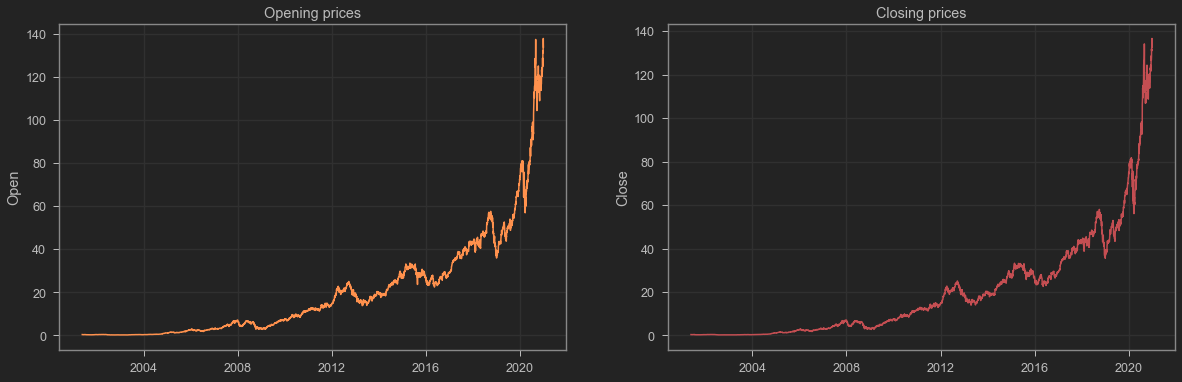

In [29]:
fig,ax=plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=df,x=df.index,y="Open",ax=ax[0],color="y").set_title("Opening prices")
sns.lineplot(data=df,x=df.index,y="Close",ax=ax[1],color="r").set_title("Closing prices")

### 6.2 Visualizing the volume change over the years

Text(0.5, 1.0, 'Variation in stock volumes of apple from 2001-20')

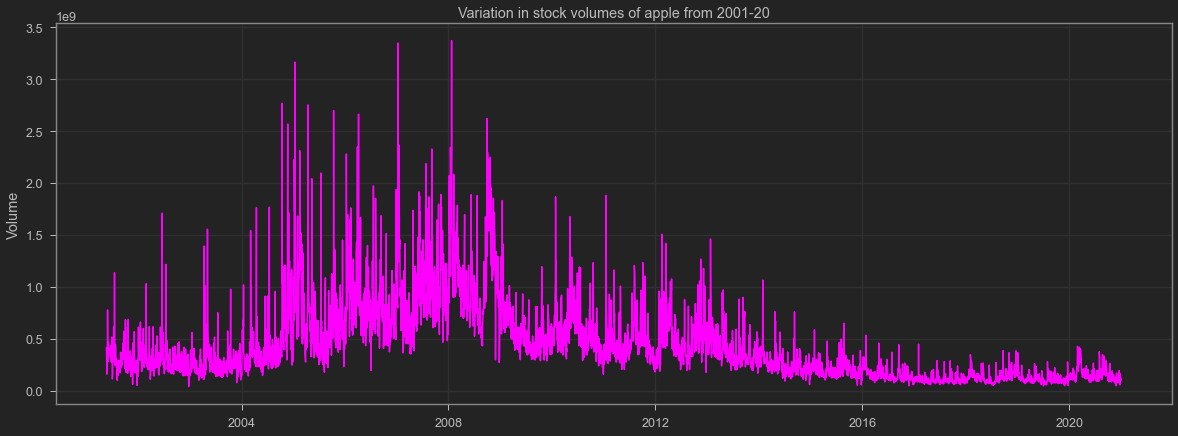

In [32]:
### visualizing the volume change over the years
plt.figure(figsize=(20,7))
sns.lineplot(data=df,x=df.index,y="Volume",color="magenta").set_title("Variation in stock volumes of apple from 2001-20")

### 6.3 Statistical analysis of the data

In [33]:
# defining a function to analyse the numerical features statistically
def feature_stats(df,feature):
    #creating the subplots
    fig,ax=plt.subplots(1,3,figsize=(15,5))
    #adding the distribution plot
    sns.distplot(x=df[feature],kde=True,ax=ax[0],color="r").set_title("distribution plot of "+feature)
    #adding the probability plot
    stats.probplot(x=df[feature],plot=ax[1])
    #adding boxplot
    sns.boxplot(x=df[feature],ax=ax[2],color="g").set_title("boxplot of "+feature) 

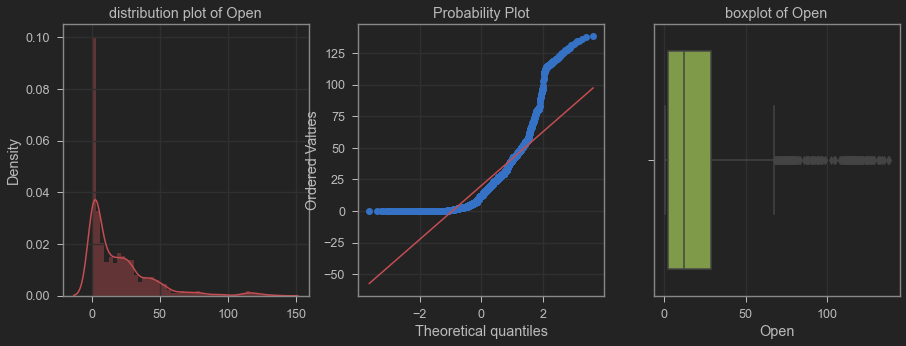

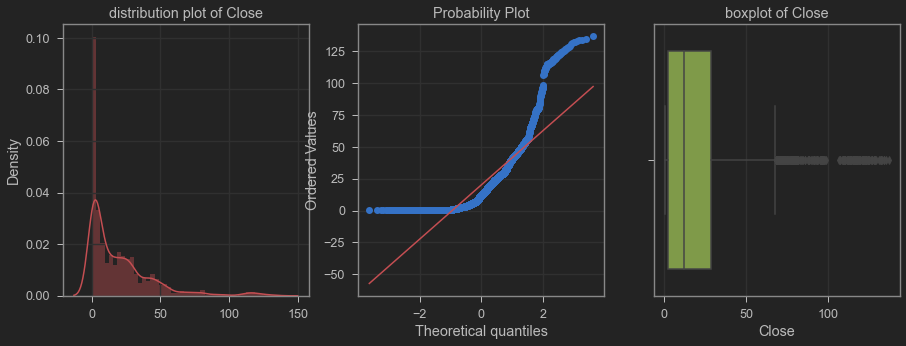

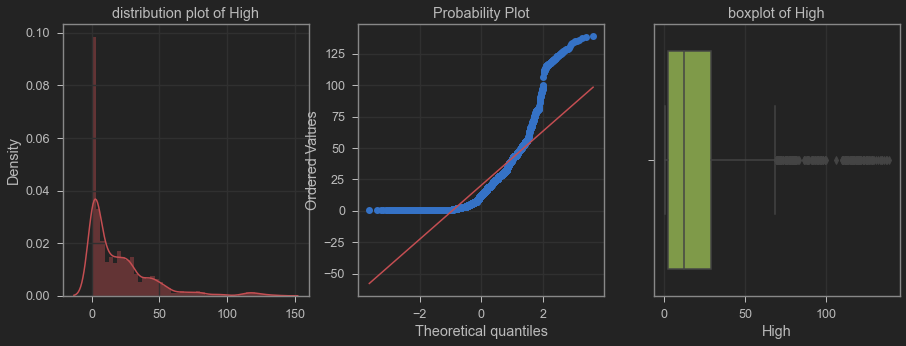

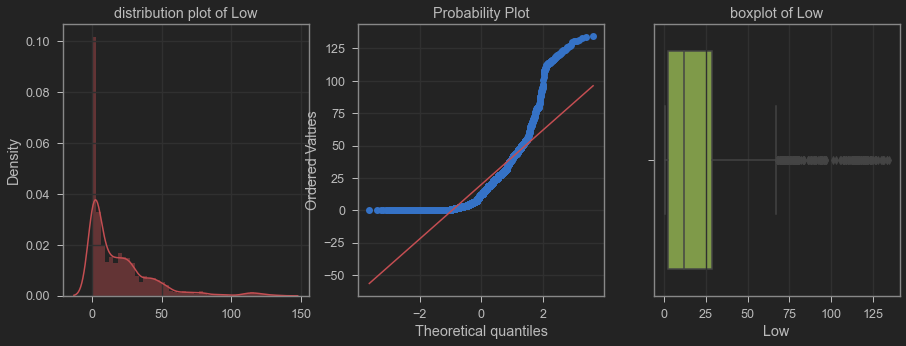

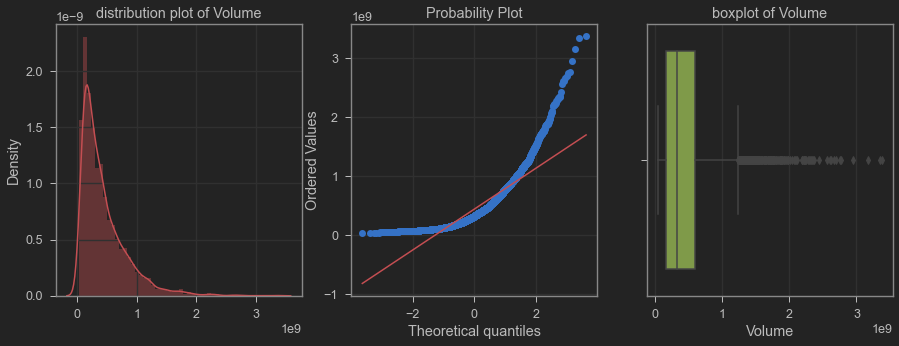

In [36]:
#improting stats libs
from scipy import stats
#selecting the columns we are performing statistical analysis on
cols=["Open","Close","High","Low","Volume"]
#itrerating over the columns
for i in cols:
    feature_stats(df,i)
    plt.show()

_________________________________